import library

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
#import library we may use in this research

some useful definition

In [3]:
# define the function of data spliting
def data_spilt(data, orders, start):
    x_train = np.empty((len(data) - start - orders, orders))
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]

    # Exclude the day (Feb. 12, 2020) of the change of the definition of confirmed cases in Hubei China.
    x_train = np.delete(x_train, np.s_[28 - (orders + 1) - start:28 - start], 0)
    y_train = np.delete(y_train, np.s_[28 - (orders + 1) - start:28 - start])

    return x_train, y_train


#define the ridge regression
def ridge(x, y):
    print('\nStart searching good parameters for the task...')
    parameters = {'alpha': np.arange(0, 0.100005, 0.000005).tolist(),
                  "tol": [1e-8],
                  'fit_intercept': [True, False],
                  'normalize': [True, False]}

    clf = GridSearchCV(Ridge(), parameters, n_jobs=-1, cv=5)
    clf.fit(x, y)

    print('\nResults for the parameters grid search:')
    print('Model:', clf.best_estimator_)
    print('Score:', clf.best_score_)

    return clf

dataset loading

In [4]:
# this can be substitute by the VA_situation_revised.csv file if can't find the file
data = pd.read_csv("/content/drive/MyDrive/stats_402/SIR model/VA_situation_revised.csv")

In [5]:
# this can be substitute by the VDH-COVID-19-PublicUseDataset-KeyMeasures-Hospitals (3).csv file if can't find the file
hospitalization = pd.read_csv("/content/drive/MyDrive/stats_402/EDA/hospitalization/VDH-COVID-19-PublicUseDataset-KeyMeasures-Hospitals (3).csv")
# this can be substitute by the Virginia recover data.csv file if can't find the file
recover_data = pd.read_csv("/content/drive/MyDrive/stats_402/recover data/Virginia recover data.csv")

overall situation

In [6]:
# the data we used in stage 2 which lacks the recover data
X_cml = np.array(data['tot_cases'])[0:100]
date = np.array(data['submission_date'])[0:100]
death = np.array(data['tot_death'])[0:100]

new_case = np.array(data['new_case'])[0:100]
new_death = np.array(data['new_death'])[0:100]
recover_rate=0.2645743266463747
recovered = X_cml*recover_rate
population = 8603985

with recover data

In [7]:
# the final data we use
X_cml = np.array(recover_data['Confirmed'])[0:315]
date = np.array(recover_data['date'])[0:315]
death = np.array(recover_data['Deaths'])[0:315]
recovered = np.array(recover_data['Recovered'])[0:315]

new_case = np.array(data['new_case'])[0:100]
new_death = np.array(data['new_death'])[0:100]

population = 8603985

split dataset

In [8]:
#import the library
from sklearn.model_selection import train_test_split

In [9]:
index = recover_data['index'][33:300]-1

In [10]:
index_train,index_test = train_test_split(index,test_size=0.3,random_state=2)
index_list = index_test.to_list()

In [11]:
#spilt the data into train data and test data to test the MSE performance of the model
X_cml_train,X_cml_test,date_train,date_test,death_train,death_test,recovered_train,recovered_test = train_test_split(X_cml,date,death,recovered,test_size=0.3,random_state=2)

main body

In [12]:
# define the data processing function which will used in the main function
def processing(X_cml,date,death,recovered):
  X = X_cml - recovered - death
  R = recovered + death

  n = np.array([population] * len(X), dtype=np.float64)

  S = n - X - R

  X_diff = np.array([X[:-1], X[1:]], dtype=np.float64).T
  R_diff = np.array([R[:-1], R[1:]], dtype=np.float64).T

  gamma = (R[1:] - R[:-1]) / X[:-1]
  beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]))
  R0 = beta / gamma
  return X,R,n,S,X_diff,R_diff,gamma,beta,R0

In [13]:
import warnings
warnings.filterwarnings("ignore")
# define the main function
def SIR(X_cml,death,recovered,stop_X,stop_day):
  # recall the data processing function
  X,R,n,S,X_diff,R_diff,gamma,beta,R0 = processing(X_cml,date,death,recovered)

  # decide the orders of the function
  orders_beta = 4
  orders_gamma = 4

  # decides the starting beta and gamma
  start_beta = 10
  start_gamma = 10

  # ridge regression
  # Split the data to the training set and testing set
  x_beta, y_beta = data_spilt(beta, orders_beta, start_beta)
  x_gamma, y_gamma = data_spilt(gamma, orders_gamma, start_gamma)



  # train and testing
  clf_beta = Ridge(alpha=0.003765, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_beta, y_beta)
  clf_gamma = Ridge(alpha=0.001675, copy_X=True, fit_intercept=False, max_iter=None,normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_gamma, y_gamma)

  beta_hat = clf_beta.predict(x_beta)
  gamma_hat = clf_gamma.predict(x_gamma)


  # test data preprocess 
  test_x = np.array(recover_data['Confirmed'])[0:200]

  test_death = np.array(recover_data['Deaths'])[0:200]

  test_recovered = np.array(recover_data['Recovered'])[0:200]
  
  test_X = test_x - test_recovered - test_death
  test_R = test_recovered + test_death

  # Time-dependent SIR model 

  






  day_count = 0
  turning_point = 0

  S_predict = [S[-1]]
  X_predict = [X[-1]]
  R_predict = [R[-1]]

  predict_beta = np.array(beta[-orders_beta:]).tolist()
  predict_gamma = np.array(gamma[-orders_gamma:]).tolist()
  while (X_predict[-1] >= stop_X) and (day_count <= stop_day):
      if predict_beta[-1] > predict_gamma[-1]:
          turning_point += 1

      next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
      next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

      if next_beta < 0:
          next_beta = 0
      if next_gamma < 0:
          next_gamma = 0

      predict_beta.append(next_beta)
      predict_gamma.append(next_gamma)

      next_S = ((-predict_beta[-1] * S_predict[-1] *
                X_predict[-1]) / n[-1]) + S_predict[-1]
      next_X = ((predict_beta[-1] * S_predict[-1] * X_predict[-1]) /
                n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1]
      next_R = (predict_gamma[-1] * X_predict[-1]) + R_predict[-1]

      S_predict.append(next_S)
      X_predict.append(next_X)
      R_predict.append(next_R)

      day_count += 1

  #return the answer
  return X_predict,R_predict

#SIR(X_cml,death,recovered,0,0)

In [14]:
# recall some important values
X,R,n,S,X_diff,R_diff,gamma,beta,R0 = processing(X_cml,date,death,recovered)

MSE

In [15]:
#import library
from sklearn.metrics import *

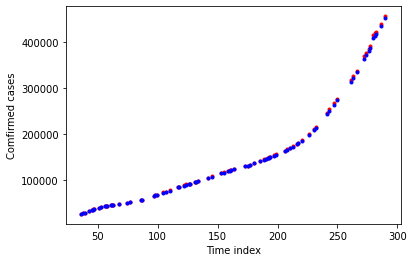

the mean absolute percentage error is 0.01126210830555757


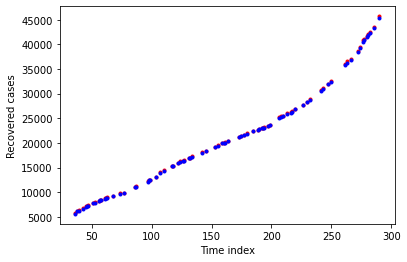

the mean absolute percentage error is 0.00662945585704631


In [16]:
# establish an empty list for use
X_predict = []
death_predict = []
R_predict = []
x_cml_predict = []
X_real = []
R_real = []
x_cml_real = []


# test the MSE performance
for i in index_list:
  i=int(i)+1
  X_cml_temp = X_cml[:i]
  death_temp = death[:i]
  recovered_temp = recovered[:i]
  #print(i)
  X_temp,R_temp = SIR(X_cml_temp,death_temp,recovered_temp,0,0)
  X_predict.append(X_temp[-1])
  R_predict.append(R_temp[-1])
  #x_cml_predict.append(x_cml_temp[-1])
  X_real.append(X[i-1])
  R_real.append(R[i-1])
  #x_cml_real.append(X_cml[i-1])

#visualize and show the result
plt.figure(1)
plt.scatter(index_list,X_predict,c='r',marker='.')
plt.scatter(index_list,X_real,c='b',marker='.')
plt.xlabel('Time index')
plt.ylabel('Comfirmed cases')
plt.show()
X_error = mean_absolute_percentage_error(X_real,X_predict)
print('the mean absolute percentage error is '+str(X_error))

plt.figure(2)
plt.scatter(index_list,R_predict,c='r',marker='.')
plt.scatter(index_list,R_real,c='b',marker='.')
plt.xlabel('Time index')
plt.ylabel('Recovered cases')
plt.show()
R_error = mean_absolute_percentage_error(R_real,R_predict)
print('the mean absolute percentage error is '+str(R_error))

Sliding window

In [17]:
index_window = recover_data['index'][:315]-1

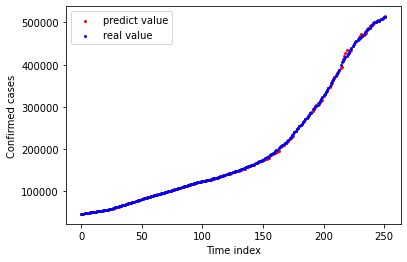

the mean absolute percentage error of existing confirmed case is 0.005656338434902154
the R square score of existing confirmed case is 0.9997484932609789
the normalized MSE of existing confirmed case is 24.485011824663026
the normalized root MSE of existing confirmed case is 0.011084101772345801
the MSE of existing confirmed case is 4879773.0782786505


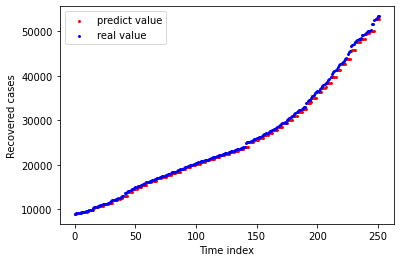

the mean absolute percentage error of recover case is 0.01517254484802269
the R square score of confirmed case is 0.9978106791586955
the normalized MSE of confirmed case is 12.362926551984101
the normalized root MSE of confirmed case is 0.021984514338825954
the MSE of confirmed case is 316234.1927679099


In [18]:
# establish an empty list for use
X_predict = []
death_predict = []
R_predict = []
X_real = []
R_real = []
x_cml_predict = []
x_cml_real = []

#set the intial value of the Sliding window
window_range = 60
predict_range = 4
index_list = []
number = 0
index_window

#sliding window
while number + window_range +predict_range + 1 < len(index_window):
  number = number + predict_range
  X_cml_temp = X_cml[number:number + window_range]
  death_temp = death[number:number + window_range]
  recovered_temp = recovered[number:number + window_range]
  X_temp,R_temp = SIR(X_cml_temp,death_temp,recovered_temp,0,predict_range)
  #print(len(X_temp))
  for i in X_temp[1:-1]:
    X_predict.append(i)

  for i in R_temp[1:-1]:
    R_predict.append(i)

  #for i in x_cml_temp[1:-1]:
    #x_cml_predict.append(i)

  #X_real.append(X[number+window_range+predict_range-1])
  #R_real.append(R[number+window_range+predict_range-1])
  
  for i in range(number+window_range,number+window_range+predict_range):
    if i == 315:
      X_real.append(X[-1])
      R_real.append(R[-1])
    else:
      X_real.append(X[i])
      R_real.append(R[i])
    #x_cml_real.append(X[i]+R[i])

  
for i in range(len(X_predict)):
  index_list.append(i)


#visualize and show the result

plt.figure(1)
plt.scatter(index_list,X_predict,c='r',marker='.',linewidths=0.0001,label='predict value')
plt.scatter(index_list,X_real,c='b',marker='.',linewidths=0.0001,label='real value')
plt.xlabel('Time index')
plt.ylabel('Confirmed cases')
plt.legend()
plt.show()
X_error = mean_absolute_percentage_error(X_real,X_predict)
X_R2 = r2_score(X_real,X_predict)
X_mmse = mean_squared_error(X_real,X_predict)/np.average(X_real)
X_mr = mean_squared_error(X_real,X_predict,squared=False)/np.average(X_real)
X_mse = mean_squared_error(X_real,X_predict)

print('the mean absolute percentage error of existing confirmed case is '+str(X_error))
print('the R square score of existing confirmed case is '+str(X_R2))
print('the normalized MSE of existing confirmed case is '+str(X_mmse))
print('the normalized root MSE of existing confirmed case is '+str(X_mr))
print('the MSE of existing confirmed case is '+str(X_mse))



plt.figure(2)
plt.scatter(index_list,R_predict,c='r',marker='.',linewidths=0.001,label='predict value')
plt.scatter(index_list,R_real,c='b',marker='.',linewidths=0.001,label='real value')
plt.xlabel('Time index')
plt.ylabel('Recovered cases')
plt.legend()
plt.show()
R_error = mean_absolute_percentage_error(R_real,R_predict)
R_R2 = r2_score(R_real,R_predict)
R_mmse = mean_squared_error(R_real,R_predict)/np.average(R_real)
R_mr = mean_squared_error(R_real,R_predict,squared=False)/np.average(R_real)
R_mse = mean_squared_error(R_real,R_predict)
print('the mean absolute percentage error of recover case is '+str(R_error))
print('the R square score of confirmed case is '+str(R_R2))
print('the normalized MSE of confirmed case is '+str(R_mmse))
print('the normalized root MSE of confirmed case is '+str(R_mr))
print('the MSE of confirmed case is '+str(R_mse))

x_cml_real = sum(X_real,R_real).tolist()
x_cml_predict = sum(X_predict,R_predict).tolist()



In [19]:
# output the number
# if don't use the google colab, please ignore this step
X_predict_pd = pd.DataFrame(X_predict,columns=['existing case (predicted)'])
R_predict_pd = pd.DataFrame(R_predict,columns=['reduced case (predicted)'])
X_real_pd = pd.DataFrame(X_real,columns=['existing case (real)'])
R_real_pd = pd.DataFrame(R_real,columns=['reduced case (real)'])
result=pd.concat([X_predict_pd,R_predict_pd,X_real_pd,R_real_pd], axis=1)
result.to_csv('SIR_result.csv',index=False)
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored